In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
fake_videos_path = '/SDFVD/videos_fake'
real_videos_path = '/SDFVD/videos_real'


def extract_frames(video_path, label, num_frames=30, img_size=(128, 128)):
    frames = []
    labels = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)

    for i in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        if i in frame_indices:
            frame = cv2.resize(frame, img_size)
            frames.append(frame)
            labels.append(label)
    cap.release()
    return frames, labels

# Process videos
def load_videos_from_folder(folder_path, label):
    all_frames, all_labels = [], []
    for video_name in os.listdir(folder_path):
        video_path = os.path.join(folder_path, video_name)
        frames, labels = extract_frames(video_path, label)
        all_frames.extend(frames)
        all_labels.extend(labels)
    return all_frames, all_labels

# Load data
real_frames, real_labels = load_videos_from_folder(real_videos_path, 0)
fake_frames, fake_labels = load_videos_from_folder(fake_videos_path, 1)

# Combine data
X = np.array(real_frames + fake_frames) / 255.0
y = np.array(real_labels + fake_labels)

print(f"Total Frames: {len(X)}, Real: {len(real_frames)}, Fake: {len(fake_frames)}")

Total Frames: 3180, Real: 1590, Fake: 1590


In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training Frames: {len(X_train)}, Testing Frames: {len(X_test)}")

Training Frames: 2544, Testing Frames: 636


In [ ]:
# making the CNN model 
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)
# Increasing number of epochs will increase the accuracy of model

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4770 - loss: 0.7903 - val_accuracy: 0.5128 - val_loss: 0.6931
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5058 - loss: 0.6931 - val_accuracy: 0.5128 - val_loss: 0.6930
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.4989 - loss: 0.6932 - val_accuracy: 0.5128 - val_loss: 0.6931
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4875 - loss: 0.6932 - val_accuracy: 0.5128 - val_loss: 0.6930
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5028 - loss: 0.6931 - val_accuracy: 0.5128 - val_loss: 0.6931
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4929 - loss: 0.6933 - val_accuracy: 0.5147 - val_loss: 0.6930
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5218 - loss: 0.6933 - val_accuracy: 0.5128 - val_loss: 0.6931
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5092 - loss: 0.6930 - val_accuracy: 0.4872 - val_loss:

In [7]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step - accuracy: 0.7776 - loss: 0.7121
Test Accuracy: 78.77%


In [ ]:
# for confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step


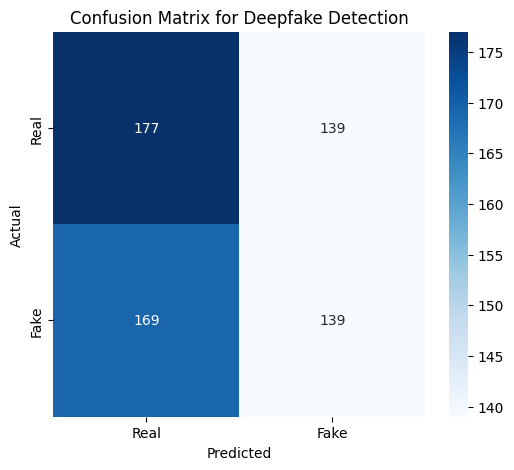

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.56      0.53       316
           1       0.50      0.45      0.47       308

    accuracy                           0.51       624
   macro avg       0.51      0.51      0.50       624
weighted avg       0.51      0.51      0.50       624



In [ ]:

# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Deepfake Detection')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
model.save('/deepfake_detection_video_model.keras')